In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from textwrap import wrap
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')

# Load data

In [10]:
pgroup = 'p20537'
Loaddir_name = 'Reduced_XANES_timescans_TT'

runlist=np.arange(166, 169)

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
try:
    print ('{} scans of {} steps each, {} shots'.format(len(runlist), np.shape(Pump_probe_Diode1)[1], len(Pump_probe_scan)))
except:
    print ('No TT data found')
    print ('{} scans of {} steps each'.format(len(runlist), np.shape(Pump_probe_Diode1)[1]))

[166 167 168]
3 scans of 56 steps each, 13322 shots


# ONE diode: 
* [Averaged curves w/o TT](#Ave_data_noTT)
* [Averaged curves with TT](#Ave_data_TT)
* [Overlay different scans](#Overlay_1diode)

# TWO diodes:
* [Averaged curves w/o TT](#Ave_data_noTT_2)
* [Overlay different scans](#Overlay_2diodes)


<a id='Ave_data_noTT'></a>
## Average scans w/o TT (same delay axis) 1 diode

In [11]:
#### CH1 ####
DataDiode1_pump   = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1        = np.asarray(goodshots1)

XAS1_pump        = np.mean(DataDiode1_pump[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump[:,:,0]-DataDiode1_pump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump[:,:,2]-DataDiode1_pump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump[:,:,0]-DataDiode1_unpump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump[:,:,2]-DataDiode1_unpump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe_Diode1[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)


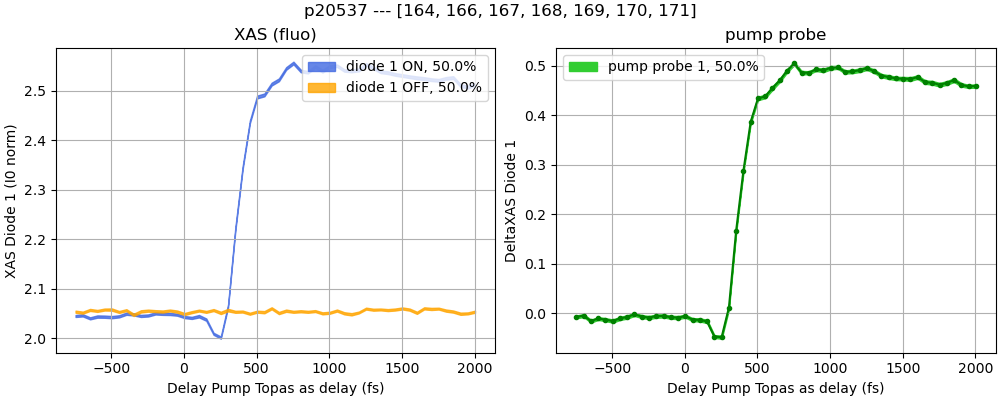

In [12]:
quantile_corr = 0.5
Delay_fs = np.asarray(Delay_fs[0])

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle(titlestring_stack)

ax1.fill_between(Delay_fs, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Delay_fs, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Delay_fs, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Delay_fs, XAS1_pump_probe, color='green', marker='.')

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("{} ({})".format(label, units))
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()


plt.show()

## save the averaged spectra

In [13]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe_Diode1[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1, axis=0)

#save_run_array_timescans(reducedir, run_name, Delay_fs, Delay_fs, DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg)
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0164-FePhen_timescan_7119p5eV


<a id='Ave_data_TT'></a>
## Average scans with TT (re-bin X axis) 1 diode

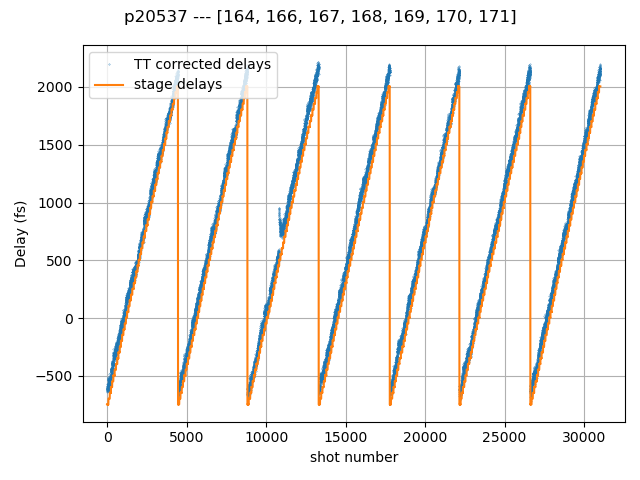

In [14]:
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(Delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.tight_layout()
plt.grid()
plt.show()

### variable binsize

In [15]:
numbins = 100
withTT = True

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan), np.shape(Delays_fs_scan))

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin),
                     np.arange(npt),
                     np.sort(x))

if not withTT:
    binList = histedges_equalN(Delays_fs_scan, numbins)
    pp_TT, binEdges, binNumber = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='mean', bins=binList)
else:
    binList = histedges_equalN(Delays_corr_scan, numbins)
    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)

bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.copy(bin_centres)
count = []
for index in range(len(bin_centres)):
    count.append(np.count_nonzero(binNumber == index))

(31024,) (31024,) (31024,)


### fix binsize with a range

In [279]:
binsize = 25 # in fs
withTT = True

min_delay = -700
max_delay = 2200

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan), np.shape(Delays_fs_scan))

binList = np.arange(min_delay, max_delay, binsize)

if not withTT:
    pp_TT, binEdges, binNumber = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='mean', bins=binList)
else:
    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)

bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
count = []
for index in range(len(bin_centres)):
    count.append(np.count_nonzero(binNumber == index))

(13304,) (13304,) (13304,)


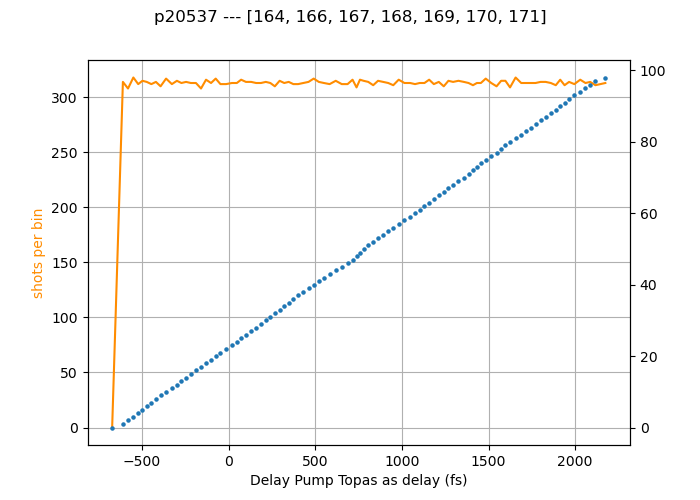

In [16]:
fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(Delay_fs_TT), 1)
ax1.plot(Delay_fs_TT, np.array(count), color = 'darkorange')
ax2.scatter(Delay_fs_TT, delayrange, s = 5)

ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()

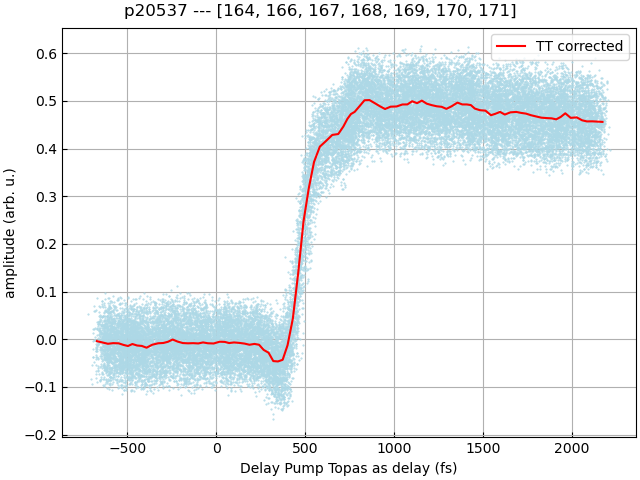

In [17]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring_stack)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

plt.plot(Delays_corr_scan, Pump_probe_scan, 'o', color='lightblue', markersize=0.5)
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
# plt.ylim(-0.18, 0.68)
# plt.xlim(-800, 2200)
plt.grid()
#plt.axvline(0)

plt.show()

<a id='Overlay_1diode'></a>
## Overlay different scans 1 diode

In [18]:
pgroup = 'p20537'
runlist = np.arange(166, 171, 1)
#runlist = [164, 166]
Loaddir_folder = 'Reduced_XANES_timescans_TT'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 5 runs: [166 167 168 169 170] from /sf/alvra/data/p20537/work/Claudio/Reduced_XANES_timescans_TT/


['/sf/alvra/data/p20537/work/Claudio/Reduced_XANES_timescans_TT/run0166-FePhen_timescan_7119p5eV_001/run_array.npy',
 '/sf/alvra/data/p20537/work/Claudio/Reduced_XANES_timescans_TT/run0167-FePhen_timescan_7119p5eV_002/run_array.npy',
 '/sf/alvra/data/p20537/work/Claudio/Reduced_XANES_timescans_TT/run0168-FePhen_timescan_7119p5eV_003/run_array.npy',
 '/sf/alvra/data/p20537/work/Claudio/Reduced_XANES_timescans_TT/run0169-FePhen_timescan_7119p5eV_004/run_array.npy',
 '/sf/alvra/data/p20537/work/Claudio/Reduced_XANES_timescans_TT/run0170-FePhen_timescan_7119p5eV_005/run_array.npy']

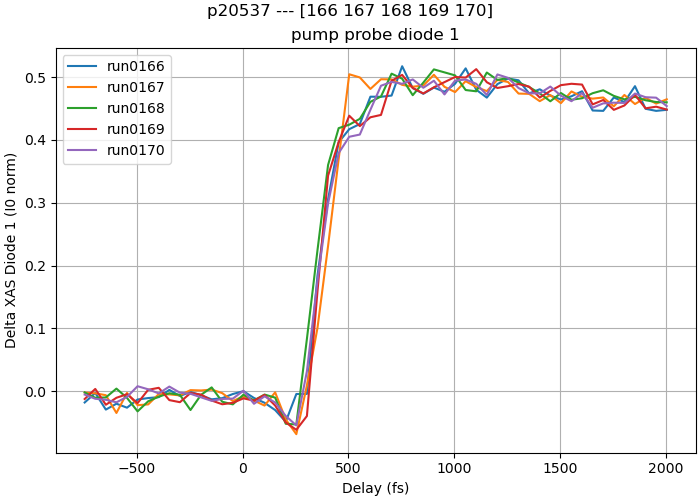

In [19]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

keys = []
#lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Delay_fs = run_array[key]["Delay_fs"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Delay_fs, XAS1_pump_probe[:,0], label=runnumber)
        #ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe)
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
#ax1.set_xlim(-1000, 50000)
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')
plt.show()

<a id='Ave_data_noTT_2'></a>
## Average scans (same X axis) 2 diodes

In [29]:
#### CH1 ####
DataDiode1_pump   = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1        = np.asarray(goodshots1)

XAS1_pump        = np.mean(DataDiode1_pump[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump[:,:,0]-DataDiode1_pump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump[:,:,2]-DataDiode1_pump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump[:,:,0]-DataDiode1_unpump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump[:,:,2]-DataDiode1_unpump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe_Diode1[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
DataDiode2_pump   = np.asarray(DataDiode2_pump)
DataDiode2_unpump = np.asarray(DataDiode2_unpump)
Pump_probe_Diode2 = np.asarray(Pump_probe_Diode2)
goodshots2        = np.asarray(goodshots2)

XAS2_pump        = np.mean(DataDiode2_pump[:,:,0], axis=0)
err2_low_pump    = np.mean((DataDiode2_pump[:,:,0]-DataDiode2_pump[:,:,1])/np.sqrt(goodshots2), axis=0)
err2_high_pump   = np.mean((DataDiode2_pump[:,:,2]-DataDiode2_pump[:,:,0])/np.sqrt(goodshots2), axis=0)

XAS2_unpump      = np.mean(DataDiode2_unpump[:,:,0], axis=0)
err2_low_unpump  = np.mean((DataDiode2_unpump[:,:,0]-DataDiode2_unpump[:,:,1])/np.sqrt(goodshots2), axis=0)
err2_high_unpump = np.mean((DataDiode2_unpump[:,:,2]-DataDiode2_unpump[:,:,0])/np.sqrt(goodshots2), axis=0)

XAS2_pump_probe       = np.mean(Pump_probe_Diode2[:,:,0], axis=0)
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

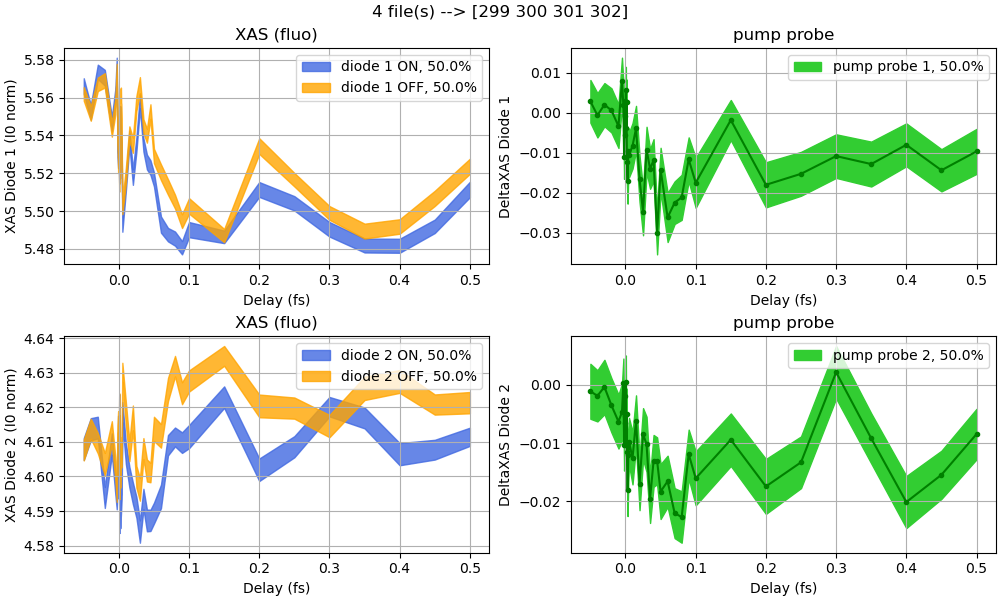

In [30]:
quantile_corr = 0.5
Delay_fs = np.asarray(Delay_fs[0])

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

ff = glob.glob(Loaddir+'/*{:04d}*/timescan_Delay_fs.npy'.format(runlist[0]))
Delay_fs = np.load(ff[0])

ax1.fill_between(Delay_fs, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Delay_fs, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Delay_fs, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Delay_fs, XAS1_pump_probe, color='green', marker='.')

try:
    ax2.fill_between(Delay_fs, XAS2_pump - err2_low_pump, XAS2_pump + err2_high_pump , label='diode 2 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
    ax2.fill_between(Delay_fs, XAS2_unpump - err2_low_unpump, XAS2_unpump + err2_high_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
    ax4.fill_between(Delay_fs, XAS2_pump_probe - err2_low_pump_probe, XAS2_pump_probe + err2_low_pump_probe, label='pump probe 2, {}%'.format(quantile_corr*100),color='limegreen')
    ax4.plot(Delay_fs, XAS2_pump_probe, color='green', marker='.')
except:
    print ('Diode2 files not found')
    
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("Delay (fs)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("XAS Diode 2 (I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax4.set_xlabel("Delay (fs)")
ax4.set_ylabel ("DeltaXAS Diode 2")
ax4.set_title('pump probe')
ax4.legend(loc="best")
ax4.grid()

plt.show()

## save the averaged spectra to load them overlaid

In [25]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe_Diode1[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1, axis=0)
DataDiode2_pump_avg   = np.mean(DataDiode2_pump[:,:,:], axis=0)
DataDiode2_unpump_avg = np.mean(DataDiode2_unpump[:,:,:], axis=0)
Pump_probe2_avg       = np.mean(Pump_probe_Diode2[:,:,:], axis=0)
goodshots2_avg        = np.mean(goodshots2, axis=0)

# save_run_array_timescans_2diodes(reducedir, run_name, Delay_mm, Delay_fs, 
#                                  DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg, 
#                                  DataDiode2_pump_avg, DataDiode2_unpump_avg, Pump_probe2_avg, goodshots2_avg)
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0299-RuRh_ClK_timescan_2819p7eV_500ps_001


<a id='Overlay_2diodes'></a>
## Overlay different scans 2 diodes

In [26]:
pgroup = 'p20774'
runlist = np.arange(49, 51, 1)
#runlist = [217,277,280]
Loaddir_folder = 'Reduced_XANES_timescans'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [49 50] from /sf/alvra/data/p20774/work/Claudio/Reduced_XANES_timescans/


['/sf/alvra/data/p20774/work/Claudio/Reduced_XANES_timescans/run0049-RuRh_RuL3_timescan_2840p3eV_001/run_array.npy',
 '/sf/alvra/data/p20774/work/Claudio/Reduced_XANES_timescans/run0050-RuRh_RuL3_timescan_2840p3eV_002/run_array.npy']

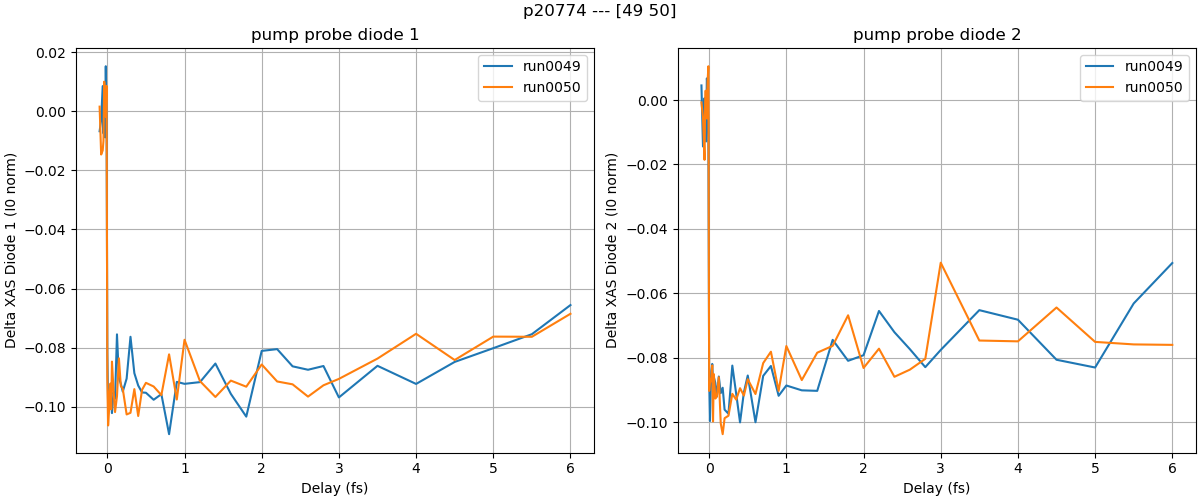

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Delay_fs = run_array[key]["Delay_fs"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Delay_fs, XAS1_pump_probe[:,0], label=runnumber)
        #ax1.plot(Delay_fs, (D1u[:,0] - np.mean(D1u[:5,0])) , label=runnumber)
        #ax2.plot(Delay_fs, (D1u[:,0] - np.mean(D1u[:5,0]))/np.max(D1u[:,0]) , label=runnumber)
        #ax1.plot(Delay_fs, D1p[:,0])
        #ax1.axes.errorbar(Delay_fs, D1u[:,0], err1_low_unpump, err1_high_unpump, label=runnumber)
        #ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
        D2p = run_array[key]["DataDiode2_pump"]
        D2u = run_array[key]["DataDiode2_unpump"]
        gs2 = run_array[key]["goodshots2"]

        err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
        err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
        err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
        err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)

        err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
        err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

        ax2.plot(Delay_fs, XAS2_pump_probe[:,0], label=runnumber)
        #ax2.axes.errorbar(Delay_fs, D2u[:,0], err2_low_unpump, err2_high_unpump, label=runnumber)
        
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 1')
ax2.set_title('pump probe diode 2')

plt.show()

In [ ]:
pgroup = 'p20537'
Loaddir_name = 'Reduced_XANES_timescans_TT'

runlist = list([164]) + list(np.arange(166, 172))

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)
# Timezero_mm = get_timezero_NBS(firstrun)
# Delay_mm, Delay_fs = adjust_delayaxis(scan,scan.readbacks,Timezero_mm)
# titlestring_stack = pgroup + ' --- ' +str(runlist)

DataDiode1_pump = []
DataDiode1_unpump = []
Pump_probe_Diode1 = []
Pump_probe_scan = []
Delays_fs_scan = []
Delays_corr_scan = []
goodshots1 = []
datafiles = []

TTflag = True

print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))
    datafiles.extend(file)
    run_array = np.load(file[0], allow_pickle=True).item()
    for key in run_array.keys():
        DataDiode1_pump.append(run_array[key]["DataDiode1_pump"])
        DataDiode1_unpump.append(run_array[key]["DataDiode1_unpump"])
        Pump_probe_Diode1.append(run_array[key]["Pump_probe_Diode1"])
        goodshots1.append(run_array[key]["goodshots1"])
        Delay_fs = run_array[key]["Delay_fs"]
        try:
            Pump_probe_scan.extend(run_array[key]["Pump_probe_scan"])
            Delays_fs_scan.extend(run_array[key]["Delays_fs_scan"])
            Delays_corr_scan.extend(run_array[key]["Delays_corr_scan"])
        except:
            print ('No TT data found')
            TTflag = False
            
datafiles = sorted(datafiles, key = os.path.getmtime)
titlestring_stack = pgroup + ' --- ' +str(runlist)
DataDiode1_pump = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1 = np.asarray(goodshots1)

if TTflag:
    print ('{} scans, {} steps, {} shots'.format(len(datafiles), np.shape(Pump_probe_Diode1)[1], len(Pump_probe_scan)))
else:
    print ('{} scans, {} steps'.format(len(datafiles), np.shape(Pump_probe_Diode1)[1]))

In [ ]:
pgroup = 'p20774'
runlist=np.arange(299, 303)
Loaddir_name = 'Reduced_XANES_timescans'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
# Timezero_mm = get_timezero_NBS(firstrun)
# scan = SFScanInfo(firstrun)
# Delay_mm, Delay_fs = adjust_delayaxis(scan,scan.readbacks,Timezero_mm)
titlestring_stack = pgroup + ' --- ' +str(runlist)

DataDiode1_pump = []
DataDiode1_unpump = []
Pump_probe_Diode1 = []
DataDiode2_pump = []
DataDiode2_unpump = []
Pump_probe_Diode2 = []
# Pump_probe_scan = []
# Delays_fs_scan = []
# Delays_corr_scan = []
goodshots1 = []
goodshots2 = []
datafiles = []

TTflag = True

print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))
    datafiles.extend(file)
    run_array = np.load(file[0], allow_pickle=True).item()
    for key in run_array.keys():
        DataDiode1_pump.append(run_array[key]["DataDiode1_pump"])
        DataDiode1_unpump.append(run_array[key]["DataDiode1_unpump"])
        Pump_probe_Diode1.append(run_array[key]["Pump_probe_Diode1"])
        goodshots1.append(run_array[key]["goodshots1"])
        DataDiode2_pump.append(run_array[key]["DataDiode2_pump"])
        DataDiode2_unpump.append(run_array[key]["DataDiode2_unpump"])
        Pump_probe_Diode2.append(run_array[key]["Pump_probe_Diode2"])
        goodshots2.append(run_array[key]["goodshots2"])
        try:
            Pump_probe_scan.extend(run_array[key]["Pump_probe_scan"])
            Delays_fs_scan.extend(run_array[key]["Delays_fs_scan"])
            Delays_corr_scan.extend(run_array[key]["Delays_corr_scan"])
        except:
            print ('No TT data found')
            TTflag = False
            
datafiles = sorted(datafiles, key = os.path.getmtime)
titlestring_stack = pgroup + ' --- ' +str(runlist)
DataDiode1_pump = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1 = np.asarray(goodshots1)
DataDiode2_pump = np.asarray(DataDiode2_pump)
DataDiode2_unpump = np.asarray(DataDiode2_unpump)
Pump_probe_Diode2 = np.asarray(Pump_probe_Diode2)
goodshots2 = np.asarray(goodshots2)

if TTflag:
    print ('{} scans, {} steps, {} shots'.format(len(datafiles), np.shape(Pump_probe_Diode1)[1], len(Pump_probe_scan)))
else:
    print ('{} scans, {} steps'.format(len(datafiles), np.shape(Pump_probe_Diode1)[1]))